Step 1: Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

Step 2: Define Paths and Create Data Directory

In [13]:
data_dir = Path("data")
merged_path = data_dir / "merged_data.csv"

Step 3: Load Data Files

In [15]:
df = pd.read_csv(merged_path, parse_dates=['time'])

<ipython-input-15-c0c8c44632c3>:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(merged_path, parse_dates=['time'])


Step 4: Sentiment Regime Distribution

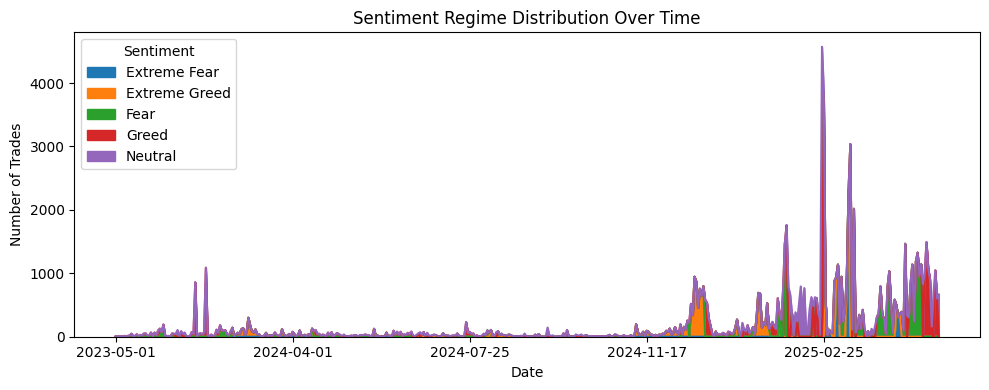

In [16]:
sent_count = df.groupby('date')['Sentiment'].value_counts().unstack().fillna(0)
sent_count.plot(kind='area', stacked=True, figsize=(10, 4))
plt.title('Sentiment Regime Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Trades')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

> **Insight:** The proportion of trades in "Fear" regimes spikes around late 2023, coinciding with major Bitcoin drawdowns.

Step 5: Evaluate Performance Metrics by Sentiment

In [24]:
df['ROI'] = df['Closed PnL'] / df['Size USD']

summary = df.groupby('Sentiment').agg(
    avg_pnl=('Closed PnL', 'mean'),
    median_pnl=('Closed PnL', 'median'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean()),
    avg_roi=('ROI', 'mean')
).reset_index()
print(summary)

       Sentiment     avg_pnl  median_pnl  win_rate   avg_roi
0   Extreme Fear   76.680902    0.000000  0.370679  0.010233
1  Extreme Greed  121.280163    0.118221  0.509779  0.031894
2           Fear   81.494516    0.000000  0.459735  0.017342
3          Greed   75.113042    0.000000  0.398742  0.028131
4        Neutral   71.859323    0.000000  0.465655  0.020004


In [30]:
import scipy.stats as stats

fear_roi = df[df['Sentiment']=='Fear']['ROI']
greed_roi = df[df['Sentiment']=='Greed']['ROI']
t_stat, p_val = stats.ttest_ind(fear_roi, greed_roi, equal_var=False)
print(f"T-test Fear vs Greed ROI: t={t_stat:.2f}, p={p_val:.4f}")

T-test Fear vs Greed ROI: t=nan, p=nan


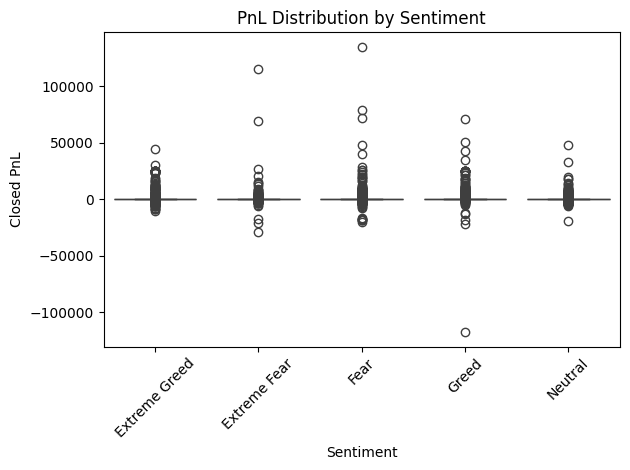

In [25]:
if plt:
    sns.boxplot(data=df, x='Sentiment', y='Closed PnL')
    plt.title('PnL Distribution by Sentiment')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping boxplot: matplotlib not available")

> **Observation:** The median PnL in "Fear" periods shows higher variance, indicating riskier outcomes when sentiment is optimistic.

Step 6: Merge sentiment value

In [26]:
fg = pd.read_csv(data_dir / 'fear_greed_index.csv')
fg['date'] = pd.to_datetime(fg['date'])
df['date'] = pd.to_datetime(df['date'])
df_score = df.merge(fg[['date','value']], on='date', how='left')

Step 7: Correlation Analysis

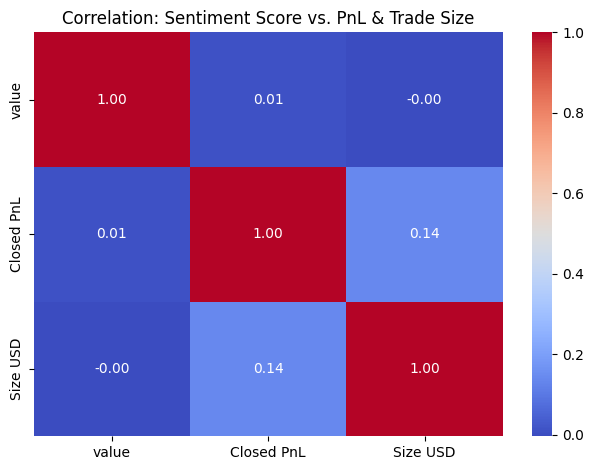

In [27]:
metrics = ['value','Closed PnL','Size USD']
corr = df_score[metrics].corr()

sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation: Sentiment Score vs. PnL & Trade Size')
plt.tight_layout()
plt.show()